In [12]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

In [6]:
def get_meta(body, attr):
    soup = BeautifulSoup(body, parser='lxml')
    metatags = soup.findAll('meta')
    attr_ = [m.get(attr, None) for m in metatags]
    attr = [a.lower() for a in attr_ if a != None]
    
    return np.unique(attr)

In [7]:
df = pd.read_json('/dlabdata1/lugeon/websites_alexa_mostpop2_html.json.gz', orient='records', lines=True)

In [8]:
df = df[(df.errcode==200) & (df.cat != 'World')]
df

,uid,url,html,errcode,cat
0,1700,http://www.photoawards.com,"<!DOCTYPE html><html lang=""en-US""><head><meta ...",200.0,Arts
2,1702,http://www.letsgodigital.org,<!DOCTYPE html><html><head><meta\nname=viewpor...,200.0,Arts
3,1703,http://www.lensculture.com,"<!DOCTYPE html>\n<html class=""mobile-friendly ...",200.0,Arts
4,1704,http://www.outdoorphotographer.com,"<!DOCTYPE html>\n<html lang=""en-US"" xmlns:fb=""...",200.0,Arts
5,1705,http://www.fiap.net,"<!DOCTYPE html>\n<html lang=""en_US"">\n<head>\n...",200.0,Arts
...,...,...,...,...,...
20055,19794,http://www.scottishathletics.org.uk,"<!DOCTYPE html>\n<!--[if IE 8]>\n<html class=""...",200.0,Sports
20056,19795,http://www.athleticsni.org,<!DOCTYPE html>\r\n<!--[if lt IE 7 ]><html cla...,200.0,Sports
20058,19797,http://www.track.eku.edu,"<html xmlns:v=""urn:schemas-microsoft-com:vml""\...",200.0,Sports
20059,19798,http://www.runnerkid.freeservers.com,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",200.0,Sports


In [9]:
df['meta_name'] = df.apply(lambda row: get_meta(row.html, 'name'), axis=1)

In [37]:
df['meta_proprety'] = df.apply(lambda row: get_meta(row.html, 'property'), axis=1)

In [38]:
df.head()

,uid,url,html,errcode,cat,meta_name,metaname_oh,meta_proprety
0,1700,http://www.photoawards.com,"<!DOCTYPE html><html lang=""en-US""><head><meta ...",200.0,Arts,"[description, follow.it-verification-code-ogjj...","[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, ...","[og:description, og:image, og:image:height, og..."
2,1702,http://www.letsgodigital.org,<!DOCTYPE html><html><head><meta\nname=viewpor...,200.0,Arts,"[apple-mobile-web-app-title, application-name,...","[0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, ...","[og:description, og:locale, og:site_name, og:t..."
3,1703,http://www.lensculture.com,"<!DOCTYPE html>\n<html class=""mobile-friendly ...",200.0,Arts,"[author, canonical, csrf-param, csrf-token, de...","[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[fb:app_id, fb:pages, og:description, og:image..."
4,1704,http://www.outdoorphotographer.com,"<!DOCTYPE html>\n<html lang=""en-US"" xmlns:fb=""...",200.0,Arts,"[description, generator, twitter:card, twitter...","[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...","[og:description, og:image, og:locale, og:site_..."
5,1705,http://www.fiap.net,"<!DOCTYPE html>\n<html lang=""en_US"">\n<head>\n...",200.0,Arts,"[csrf-token, description, handheldfriendly, th...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...","[fb:app_id, og:description, og:image, og:local..."


In [11]:
cats = df.cat.unique()

def compute_attr_presence(attr, min_pres):
    all_meta_attr = [] 

    counts = []

    for cat in cats:
        df_cat = df[df.cat == cat]
        meta_attrs = df_cat[attr].values
        count = pd.Series([a for b in meta_attrs for a in b]).value_counts() / df_cat.shape[0]
        min_count = count[count >= min_pres]
        counts.append(count)
        all_meta_attr += min_count.index.tolist()
        #print(cat)
        #print(count, '\n')

    all_meta_attr = np.unique(all_meta_attr)
    
    count_array = np.zeros((len(all_meta_attr), len(cats)))
    
    for i in range(len(cats)):
        j = 0
        for attr in all_meta_attr:
            count_array[j,i] = counts[i].get(attr, 0)
            j += 1
        
    return count_array, all_meta_attr
    

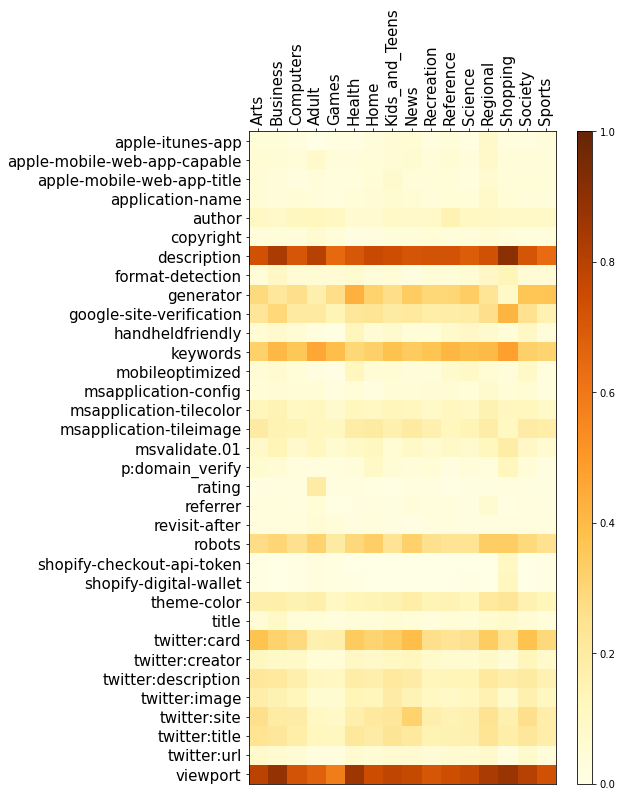

In [110]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

count_attr, attr_names = compute_attr_presence('meta_name', 0.05)

fig, ax = plt.subplots(figsize=(8, 12))

im = plt.imshow(count_attr, cmap='YlOrBr', interpolation='nearest', vmin=0, vmax=1)

plt.xticks(np.arange(len(cats)), cats, rotation=90, fontsize=15)
plt.yticks(np.arange(len(attr_names)), attr_names, fontsize=15)
ax.xaxis.tick_top()

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.3)

plt.colorbar(im, cax=cax)

#ax.title.set_text('Presence of the different kinds of "name" attribute w.r.t to categories')

plt.show()

In [139]:
std = []

for i in range(count_attr.shape[0]):
    std.append(np.std(count_attr[i]))
    
sorti = np.argsort(std)[::-1]

print('The presence-feature with the most variance are...')

for i in sorti[:20]:
    print("{:<25} {:.4f}".format(attr_names[i], std[i]))

The presence-feature with the most variance are...
generator                 0.0795
viewport                  0.0736
twitter:card              0.0663
description               0.0637
google-site-verification  0.0624
twitter:site              0.0571
keywords                  0.0511
rating                    0.0430
twitter:title             0.0405
robots                    0.0401
twitter:image             0.0383
twitter:description       0.0362
msapplication-tileimage   0.0329
msvalidate.01             0.0324
theme-color               0.0308
mobileoptimized           0.0288
handheldfriendly          0.0288
format-detection          0.0279
shopify-digital-wallet    0.0274
p:domain_verify           0.0269


In [186]:
repr_meta = attr_names[sorti[:50]]
repr_meta

array(['generator', 'viewport', 'twitter:card', 'description',
       'google-site-verification', 'twitter:site', 'keywords', 'rating',
       'twitter:title', 'robots', 'twitter:image', 'twitter:description',
       'msapplication-tileimage', 'msvalidate.01', 'theme-color',
       'mobileoptimized', 'handheldfriendly', 'format-detection',
       'shopify-digital-wallet', 'p:domain_verify',
       'shopify-checkout-api-token', 'twitter:creator',
       'apple-itunes-app', 'msapplication-tilecolor', 'author',
       'twitter:url', 'title', 'apple-mobile-web-app-capable',
       'application-name', 'referrer', 'msapplication-config',
       'apple-mobile-web-app-title', 'copyright', 'revisit-after'],
      dtype='<U28')

In [187]:
def meta_name_oh(names_list):
    onehot = np.array([int(n in names_list) for n in repr_meta])
    if onehot.sum() == 0:
        return None
    return onehot

In [188]:
df['metaname_oh'] = df.meta_name.apply(meta_name_oh)

<ipython-input-187-785af234c5d8>:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  onehot = np.array([int(n in names_list) for n in repr_meta])


In [189]:
df.head(1)

,uid,url,html,errcode,cat,meta_name,metaname_oh,meta_proprety
0,1700,http://www.photoawards.com,"<!DOCTYPE html><html lang=""en-US""><head><meta ...",200.0,Arts,"[description, follow.it-verification-code-ogjj...","[1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, ...","[og:description, og:image, og:image:height, og..."


In [190]:
df_red = df[df.metaname_oh.notnull()]
print("{:.2f}% of websites have at least one representative meta name".format(df_red.shape[0] / df.shape[0]))

0.94% of websites have at least one representative meta name


In [231]:
counts = df_red.cat.value_counts()
weights = counts / counts.sum() 
weights = 1 / weights
weights = weights / weights.sum() * weights.shape[0]
weights

Sports            0.345359
Business          0.400839
Shopping          0.518784
Computers         0.520657
Arts              0.592531
Society           0.617389
Recreation        0.643274
Health            0.660357
Science           0.819443
Games             1.224295
Reference         1.318300
News              1.363157
Home              1.560844
Kids_and_Teens    1.624122
Regional          1.877891
Adult             1.912759
Name: cat, dtype: float64

In [191]:
categories = df_red.cat.unique()

def categorize(c):
    return categories.tolist().index(c)

In [192]:
df_red['catno'] = df_red.cat.apply(categorize)

<ipython-input-192-98a03334188f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_red['catno'] = df_red.cat.apply(categorize)


In [212]:
df_red = df_red.sample(frac=1)

In [213]:
x = np.concatenate(df_red.metaname_oh.to_numpy()).ravel()
x = x.reshape(-1, repr_meta.shape[0])
x.shape

(15472, 34)

In [219]:
y = df_red.cat
y.shape

(15472,)

In [220]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

In [259]:
forest = RandomForestClassifier(n_estimators=200, max_depth=15, class_weight=weights.to_dict(), random_state=42)
forest_scores = cross_validate(forest, x, y, cv=5, n_jobs=5, scoring='balanced_accuracy', return_train_score=True)

In [260]:
forest_scores

{'fit_time': array([1.82650805, 1.78665829, 1.80399799, 1.88764167, 1.77001214]),
 'score_time': array([0.1694448 , 0.15249634, 0.17380357, 0.17751622, 0.17295718]),
 'test_score': array([0.14113979, 0.14527144, 0.14817764, 0.13384944, 0.1311526 ]),
 'train_score': array([0.43628842, 0.4380009 , 0.43990852, 0.442448  , 0.43912564])}

In [261]:
forest_scores['test_score'].mean()

0.1399181809802182